# **Toxic Comments Classification**

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

import pickle

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df = pd.read_csv('./Datasets/train.csv')

In [3]:
# lets check the glimpse of first five rows of train dataset
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# shape of train dataframe
df.shape

(159571, 8)

### Data Preprocessing

In [5]:
# Separate Independent and Dependent Variables
X = df['comment_text']
y = df.loc[:, 'toxic':].values

In [6]:
# lets check the comment maximum length 
df['comment_text'].str.len().max()

5000

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
# Text Vectorization is the process of converting text into a numerical representation.
# It transforms text into a more suitable form so that ML or DL algorithms can perform better.
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=1800,  # Maximum comment (text) size in words
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
# apply vectorizer on X
vectorized_text = vectorizer(X.values)

In [11]:
# prepare tensorflow dataset
# it converts the data stored in Pandas Data Frame into data stored in TensorFlow Data Set.
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
# cache keeps the images in memory after they're loaded off disk during the first epoch.
dataset = dataset.cache()
# For true randomness, we set the shuffle buffer to the full dataset size.
dataset = dataset.shuffle(160000)
# Batch after shuffling to get unique batches at each epoch
dataset = dataset.batch(16)
# prefetch overlaps data preprocessing and model execution while training.
dataset = dataset.prefetch(8) 

In [12]:
# train(70%), validation(20%) and test(10%) split
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### Model Building

In [13]:
# Formation of CNN model
# Sequential layer
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer/ output layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
# Compile the Model
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

### Model Training

In [16]:
# fit model for only 9 epochs
history = model.fit(train, epochs=9, validation_data=val)

Epoch 1/9
6981/6981 [==============================] - 617s 87ms/step - loss: 0.0620 - val_loss: 0.0453
Epoch 2/9
6981/6981 [==============================] - 618s 89ms/step - loss: 0.0457 - val_loss: 0.0394
Epoch 3/9
6981/6981 [==============================] - 615s 88ms/step - loss: 0.0402 - val_loss: 0.0352
Epoch 4/9
6981/6981 [==============================] - 615s 88ms/step - loss: 0.0358 - val_loss: 0.0326
Epoch 5/9
6981/6981 [==============================] - 634s 91ms/step - loss: 0.0323 - val_loss: 0.0281
Epoch 6/9
6981/6981 [==============================] - 629s 90ms/step - loss: 0.0289 - val_loss: 0.0247
Epoch 7/9
6981/6981 [==============================] - 619s 89ms/step - loss: 0.0255 - val_loss: 0.0214
Epoch 8/9
6981/6981 [==============================] - 622s 89ms/step - loss: 0.0232 - val_loss: 0.0192
Epoch 9/9
6981/6981 [==============================] - 633s 91ms/step - loss: 0.0204 - val_loss: 0.0179


### Result

<Figure size 576x360 with 0 Axes>

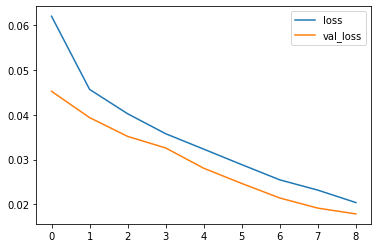

In [17]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
# save the model for future use
model.save('toxic_comments_model.h5')

### Prediction

In [19]:
# load the model
model = tf.keras.models.load_model('toxic_comments_model.h5')

In [20]:
# use text vectorization on raw data to test the model
input_text = vectorizer(np.expand_dims('I am going to hit you.',0))

In [21]:
# model prediction on raw text
res = model.predict(input_text)
print(res)

[[0.9829285  0.36757064 0.771432   0.41207135 0.6273679  0.17438579]]


In [22]:
# lets check the precision, recall and accuracy on test dataset 
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the true values
    y_true = y_true.flatten()
    # Flatten the predictions
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [23]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9402751922607422, Recall:0.8658220767974854, Accuracy:0.5195586681365967


In [26]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [27]:
print(score_comment('I am going to kill you.'))

toxic: True
severe_toxic: False
obscene: False
threat: True
insult: False
identity_hate: False



In [28]:
# save the labels for further use in deployment
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pickle.dump(labels,open('labels.pkl','wb'))